# Interview exercise : Data Science Internship

## Our problem is the following:
From a photo taken by a spectator, how to determine how to determine the area where he is located ?

To solve this problem, we will rely on a photo dataset of the Allianz Arena provided with the statement.

The first step of our reflection was to observe the photos of the data set. Each photo is taken at a different place of the stadium, some of them are blurred, but they all have a common element: the playing field is present and could be the main discriminator for our problem.

In the envisaged solution, we will thus try to locate ourselves in the stadium by comparing the positions of the field in each photograph.

![stadium_delimitation](pitch_delimitation.png)

Let us note that it seems however complicated to differentiate the positions in zones 1 and 3 then 2 and 4, an effect of symmetry being applied on the view of the field. We will then have to find another discriminating element allowing us to differentiate the symmetrical zones around the pitch axis.


Three solutions have been considered in the first instance.

## First Solution considered

The first one was to create a 3D reconstruction of the field thanks to our set of photos (which seems to make a complete turn of the stadium). This solution was based on Computer Vision concepts and included a feature extraction, feature matching, relative pose and sequence upgrade module similar to one I studied in a Computer Vision course project at Chalmers University of Technology :

![course_chalmers](course_computer_vision.png)

Although this solution was briefly explored in the notebook stadium_position.ipynb, it has been abandoned. There were two main problems: The difficulty of getting a feature extractor good enough for our use case and the movement of the camera center with each photo.

## Second Solution considered

The second solution was based on "basic" functions of the openCV library aiming at filtering and transforming each image in order to allow the detection of the contours of the ground with the help of cv2.findContours to then locate us in the stadium.

It was not selected and was not even explored in favor of the third solution.

## Third Solution (and final) considered

The third solution considered and which will finally be adopted bases its methodology on a research paper by Jianhui Chen and James J. Little entitled "Sports Camera Calibration via Synthetic Data".

The idea behind this paper is to generate a dataset of a large number of synthetic views of the field lines linked to a camera position in the stadium, then to build an AI model allowing the transposition of a photo seen from the stands to a version comprising only the field lines and then to link our generated image of the field lines to its closest image in our synthetic data in order to retrieve the position of the camera, and thus of the photographer.

We will focus on these 3 points in this assignment, trying to limit our working time to a maximum of 6 hours. We do not expect to have a perfectly functional model at the end with so little time, but to dig some interesting lines of thought to answer our problem.


##  Step 1 : Generate synthetic data
### Source : https://arxiv.org/abs/1810.10658

This part consists of building a large database of synthetic pitch edge maps (vision of pitch lines only) and corresponding camera parameters. Concerning the camera parameters, we will use the pinhole model whose equation can be written :

P = KR[I| −C]
, K being the matrix of intrinsic parameters, R the rotation matrix of the camera and C the center of the camera.

More precisely, we will define pan, tilt, roll parameters to define our synthetic cameras whose values will be calculated by trigonometry formulas from the position of the camera in order to ensure that we visualize the pitch.

Camera positions and focal length (the only variable parameter of the K-matrix) will be generated uniformly within given ranges (Alianz Arena dimensions being 258*227*50, we also ensure that the camera isn't within the pitch).

Once our synthetic camera has been created, we draw the view of the corresponding pitch lines (edge map) using utils functions.


In [128]:
# Import useful libraries
import scipy.io as sio
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from math import pi, cos, sin
import h5py
import os
import datetime
import time
from IPython import display
from skimage.color import rgb2gray

# TODO : Get homography of the pitch and get homography of the bench area by masking the output of the first GAN.
# TODO : Get stadium dimension to get the final area (drawing an ellipse around the pitch)


Let's define some useful functions

In [129]:
def project_3D_v2(P, x, y, z, w=1):
    """

    :param P:
    :param x:
    :param y:
    :param z:
    :param w:
    :return:
    """
    p = np.zeros(4)
    p[0],p[1],p[2], p[3] = x, y, z, w
    if x==52.5:
        print(x)
    q = P @ p
    assert q[2] != 0.0
    return (q[0]/q[2], q[1]/q[2])


def camera_to_edge_image_v2(ptr, cc, k_param, model_points, model_line_segment,
                             im_h=720, im_w=1280, line_width=4):
    """

    :param ptr:
    :param cc:
    :param k_param:
    :param model_points:
    :param model_line_segment:
    :param im_h:
    :param im_w:
    :param line_width:
    :return:
    """

    # Compute the rotation matrix equivalent to ptr angles
    tx, ty, tz = ptr[0], ptr[1], ptr[2]
    Rx = np.asarray([[1, 0 , 0], [0, cos(tx), -sin(tx)], [0,   sin(tx), cos(tx)]])
    Ry = np.asarray([[cos(ty), 0 , sin(ty)], [0, 1, 0], [-sin(ty),  0, cos(ty)]])
    Rz = np.asarray([[cos(tz), -sin(tz) , 0], [sin(tz), cos(tz), 0], [0,   0, 1]])

    R = Rz @ Ry @ Rx

    # Compute the intrinsic matrix
    u, v, fl = k_param[0], k_param[1], k_param[2]
    K = np.asarray([[fl, 0, u], [0, fl, v], [0, 0, 1]])

    # Compute I|-C
    I = np.zeros((3, 4))
    for i in range(3):
        I[i][i] = 1.0
        I[i][3] = -cc[i]

    # Compute P
    P = K @ R @ I

    im = np.zeros((im_h, im_w, 3), dtype=np.uint8)
    n = model_line_segment.shape[0]
    color = (255,255,255)
    for i in range(n):
        idx1, idx2 = model_line_segment[i][0], model_line_segment[i][1]
        p1, p2 = model_points[idx1], model_points[idx2]
        q1 = project_3D_v2(P, p1[0], p1[1], 0.0, 1.0)
        q2 = project_3D_v2(P, p2[0], p2[1], 0.0, 1.0)
        q1 = np.rint(q1).astype(np.int)
        q2 = np.rint(q2).astype(np.int)
        cv.line(im, tuple(q1), tuple(q2), color, thickness=line_width)
    return im

In [130]:
data = sio.loadmat('worldcup2014.mat')
model_points = data['points']
model_line_index = data['line_segment_index']

We generate our synthetic dataset.
For computing time and memory purposes, only 6000 synthetic cameras and edge views will be created. In addition, it is possible that the parameters are not optimally defined or even redundant in our dataset.
We will content ourselves with this within the framework of our exercise but would require a deepening for a real use.


A difficulty of this module lies in the large number of free parameters. Where the paper by Jianhui Chen and James J. Little has only three, here we have 7 to consider, and therefore a larger database to build.

In [131]:
# The dimension of the Allianz Arena stadium are 258*227*50
# TODO : Generalize to other stadiums as well

# Generate synthetic dataset
range_x = [-76, 181]
range_y = [-79, 147]
range_z = [5, 45]
range_fl = [100, 400]

def generate_mat_synthetic(range_x, range_y, range_z, range_fl, n_samples = 95000):
    """"""
    images = []
    cameras = []

    for i in range(n_samples):
        # print(i)
        # Sample x and y randomly within the stadium
        x = np.random.uniform(range_x[0], range_x[1])
        y = np.random.uniform(range_y[0], range_y[1])
        # Check that the camera center is not inside the playing ground
        while (-5 <= x <= 105) and (-5 <= y <= 68):
            x = np.random.uniform(range_x[0], range_x[1])
            y = np.random.uniform(range_y[0], range_y[1])
        # Sample z randomly
        z = np.random.uniform(range_z[0], range_z[1])

        # Sample fl randomly
        fl = np.random.uniform(range_fl[0], range_fl[1])

        # Define the camera center and the camera intrinsic parameters
        camera_center = np.array([x, y, z])
        k_param = [640, 360, fl]

        # Center of the pitch, will be useful to define pan, tilt, roll angles
        center = np.array([52, 34, 0])

        # Define pan to approximately have the center at the middle of the camera plan, trigonometry
        # FIXME : There is a better way to compute these angles, trigonometry do not seems well defined
        # FIXME : pan should be be defined randomly, rework the trigonometry
        pan = np.random.uniform(0.05, 0.7)

        # Define tilt
        t = camera_center.copy() ; t[2] = 0
        center_t = center.copy() ; center_t[1] = camera_center[1]
        dist_h = np.linalg.norm(camera_center-center_t)
        dist_a = np.linalg.norm(camera_center-t)
        tilt = np.arccos(dist_a/dist_h)
        # Add uncertainty
        # TODO : Check if necessary
        tilt += np.random.normal(0, 0.1)

        # Define roll
        r = camera_center.copy() ; r[1] = center[1]
        center_r = center.copy() ; center_r[2] = camera_center[2]
        dist_h = np.linalg.norm(camera_center-center_r)
        dist_a = np.linalg.norm(camera_center-r)
        roll = np.arccos(dist_a/dist_h)
        # TODO : Check if necessary
        roll += np.random.normal(0, 0.1)

        if x <= 52.5 and y <= 38:
            ptr = [-pan, tilt, roll]
        elif x > 52.5 and y <= 38:
            ptr = [-pan, -tilt, -roll]
        elif x <= 52.5 and y > 38:
            ptr = [pan, tilt, pi - roll]
        else :
            ptr = [pan, -tilt, pi + roll]

        camera = [640, 360, fl] + [x, y, z] + ptr

        im = camera_to_edge_image_v2(ptr, camera_center, k_param, model_points, model_line_index, 720, 1280, 4)
        images.append(im)
        cameras.append(camera)
        # cv.imshow('Image', im)
        # cv.waitKey(0)

    hf = h5py.File('synthetic_data_6k.hdf5', 'w')
    hf.create_dataset('images', data=np.array(images))
    hf.create_dataset('cameras', data=np.array(cameras))

    print('save training file to {}'.format('synthetic_data_6k.mat'))

    return images, cameras

# images, cameras = generate_mat_synthetic(range_x, range_y, range_z, range_fl, 6000)

Database shape :
(6000, 720, 1280, 3)

Camera corresponding to image 1 is :
[ 6.40000000e+02  3.60000000e+02  3.10547669e+02 -3.80842424e+01
  1.08793653e+02  3.95998993e+01  5.20224696e-01  1.10386714e+00
  2.20912640e+00]
Camera corresponding to image 2 is :
[ 6.40000000e+02  3.60000000e+02  3.81594822e+02  4.97199234e+01
 -4.64686438e+01  3.62032146e+01 -5.67540758e-01  1.90900199e-02
 -2.28619140e-02]
Camera corresponding to image 3 is :
[ 6.40000000e+02  3.60000000e+02  1.10272127e+02 -2.03451393e+01
  6.12738389e+01  1.19390075e+01  3.38897866e-01  1.40458014e+00
  1.76730605e+00]


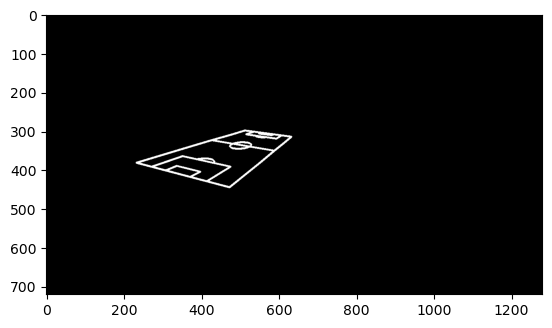

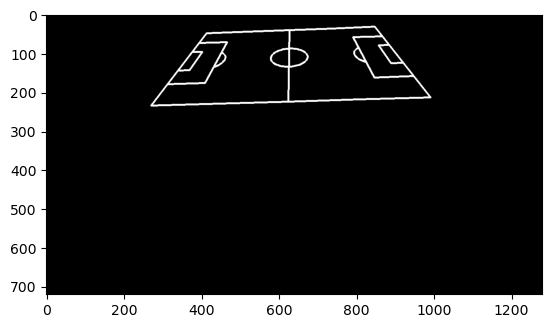

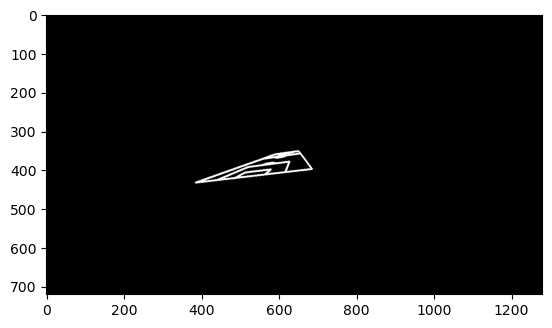

In [148]:
f = h5py.File('synthetic_data_6k.hdf5', "r")

print('Database shape :')
print(f['images'].shape)
print()

# Print the camera parameters, 640, 360, fl, x, y, z, pan, tilt, roll
print('Camera corresponding to image 1 is :')
print(f['cameras'][3])
plt.imshow(f['images'][3])
plt.show()

print('Camera corresponding to image 2 is :')
print(f['cameras'][550])
plt.imshow(f['images'][550])
plt.show()

print('Camera corresponding to image 3 is :')
print(f['cameras'][35])
plt.imshow(f['images'][35])
plt.show()

### Step 2 : Implement a double GAN to get an edge view of the pitch

Source : https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

The objective of this module is to create images similar to our edge maps with the lines of the pitch only from the photos of the spectator. We are therefore going to proceed with the implementation of two conditional GANs, one dedicated to the segmentation of the pitch and the other to the detection of its lines.


We will use the following two datasets :
The first provide photos of the pitch as input and the second this same segmented photo.

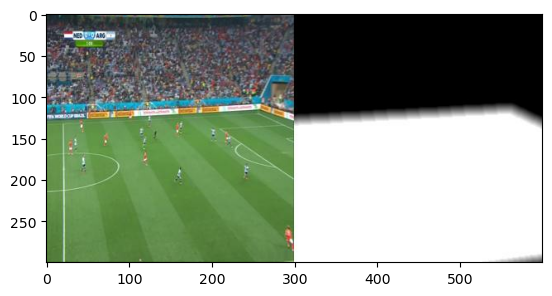

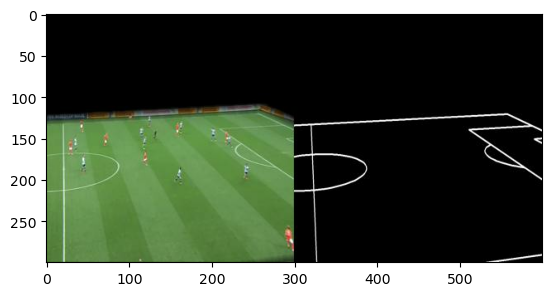

In [133]:
import tensorflow as tf

# Read the training dataset
# Training image for segmentation
image = tf.io.read_file('soccer_seg_detection/train_phase_1/001_AB.jpg')
image = tf.io.decode_jpeg(image)
plt.imshow(image)
plt.show()

# Training image for line detection
image = tf.io.read_file('soccer_seg_detection/train_phase_2/001_AB.jpg')
image = tf.io.decode_jpeg(image)
plt.imshow(image)
plt.show()

In [134]:
# Define our pix2pix conditional GAN class used for segmentation and line detection of the pitch
# Help : https://www.tensorflow.org/tutorials/generative/pix2pix

class Pix2PixModel:
    def __init__(self, train_phase=1, path='soccer_seg_detection/'):
        self.BUFFER_SIZE = 209
        self.BATCH_SIZE = 1
        self.IMG_WIDTH = 256
        self.IMG_HEIGHT = 256
        self.PATH = path
        # Segmentation is 1 and line detection 2
        self.PHASE = train_phase
        self.OUTPUT_CHANNELS = 3
        self.LAMBDA = 100
        self.generator = self.Generator()
        self.discriminator = self.Discriminator()
        self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.checkpoint_dir = './training_checkpoints_' + str(self.PHASE)
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)
        self.log_dir="logs/"

        self.summary_writer = tf.summary.create_file_writer(
          self.log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

        # Get train and test datasets
        self.cons_pipeline()

        print('initialization of phase {} done'.format(self.PHASE))

    """
    Load the data
    """
    def load(self, image_file):
        # Read and decode an image file to a uint8 tensor
        image = tf.io.read_file(image_file)
        image = tf.io.decode_jpeg(image)

        # Split each image tensor into two tensors:
        # - one with a real pitch picture image
        # - one with an edge map label image
        w = tf.shape(image)[1]
        w = w // 2
        real_image = image[:, w:, :]
        input_image = image[:, :w, :]

        # Convert both images to float32 tensors
        input_image = tf.cast(input_image, tf.float32)
        real_image = tf.cast(real_image, tf.float32)

        return input_image, real_image

    def resize(self, input_image, real_image, height, width):
        input_image = tf.image.resize(input_image, [height, width],
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        real_image = tf.image.resize(real_image, [height, width],
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return input_image, real_image

    def random_crop(self, input_image, real_image):
        stacked_image = tf.stack([input_image, real_image], axis=0)
        cropped_image = tf.image.random_crop(
        stacked_image, size=[2, self.IMG_HEIGHT, self.IMG_WIDTH, 3])

        return cropped_image[0], cropped_image[1]

    # Normalizing the images to [-1, 1]
    def normalize(self, input_image, real_image):
      input_image = (input_image / 127.5) - 1
      real_image = (real_image / 127.5) - 1

      return input_image, real_image

    @tf.function()
    def random_jitter(self, input_image, real_image):
      # Resizing to 286x286
      input_image, real_image = self.resize(input_image, real_image, 286, 286)

      # Random cropping back to 256x256
      input_image, real_image = self.random_crop(input_image, real_image)

      if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

      return input_image, real_image

    def load_image_train(self, image_file):
        input_image, real_image = self.load(image_file)
        input_image, real_image = self.random_jitter(input_image, real_image)
        input_image, real_image = self.normalize(input_image, real_image)

        return input_image, real_image

    def load_image_test(self, image_file):
        input_image, real_image = self.load(image_file)
        input_image, real_image = self.resize(input_image, real_image, self.IMG_HEIGHT, self.IMG_WIDTH)
        input_image, real_image = self.normalize(input_image, real_image)

        return input_image, real_image

    """
    Construct a pipeline with tf.data
    """
    def cons_pipeline(self):
        train_dataset = tf.data.Dataset.list_files(str(self.PATH + 'train_phase_{}/*.jpg'.format(self.PHASE)))
        train_dataset = train_dataset.map(self.load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        train_dataset = train_dataset.shuffle(self.BUFFER_SIZE)
        self.train_dataset = train_dataset.batch(self.BATCH_SIZE)

        test_dataset = tf.data.Dataset.list_files(str(self.PATH + 'test/*.jpg'))
        test_dataset = test_dataset.map(self.load_image_test)
        self.test_dataset = test_dataset.batch(self.BATCH_SIZE)

    """
    Construct the generator
    """

    def downsample(self, filters=3, size=4, apply_batchnorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(
            tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                    kernel_initializer=initializer, use_bias=False))

        if apply_batchnorm:
            result.add(tf.keras.layers.BatchNormalization())
            result.add(tf.keras.layers.LeakyReLU())
        return result

    def upsample(self, filters=3, size=4, apply_dropout=False):
       initializer = tf.random_normal_initializer(0., 0.02)

       result = tf.keras.Sequential()
       result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

       result.add(tf.keras.layers.BatchNormalization())

       if apply_dropout:
           result.add(tf.keras.layers.Dropout(0.5))

       result.add(tf.keras.layers.ReLU())
       return result

    def Generator(self):
      inputs = tf.keras.layers.Input(shape=[256, 256, 3])

      down_stack = [
        self.downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        self.downsample(128, 4),  # (batch_size, 64, 64, 128)
        self.downsample(256, 4),  # (batch_size, 32, 32, 256)
        self.downsample(512, 4),  # (batch_size, 16, 16, 512)
        self.downsample(512, 4),  # (batch_size, 8, 8, 512)
        self.downsample(512, 4),  # (batch_size, 4, 4, 512)
        self.downsample(512, 4),  # (batch_size, 2, 2, 512)
        self.downsample(512, 4),  # (batch_size, 1, 1, 512)
      ]

      up_stack = [
        self.upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        self.upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        self.upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        self.upsample(512, 4),  # (batch_size, 16, 16, 1024)
        self.upsample(256, 4),  # (batch_size, 32, 32, 512)
        self.upsample(128, 4),  # (batch_size, 64, 64, 256)
        self.upsample(64, 4),  # (batch_size, 128, 128, 128)
      ]

      initializer = tf.random_normal_initializer(0., 0.02)
      last = tf.keras.layers.Conv2DTranspose(self.OUTPUT_CHANNELS, 4,
                                             strides=2,
                                             padding='same',
                                             kernel_initializer=initializer,
                                             activation='tanh')  # (batch_size, 256, 256, 3)

      x = inputs

      # Downsampling through the model
      skips = []
      for down in down_stack:
        x = down(x)
        skips.append(x)

      skips = reversed(skips[:-1])

      # Upsampling and establishing the skip connections
      for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

      x = last(x)

      return tf.keras.Model(inputs=inputs, outputs=x)

    """
    Define the loss of the generator
    """

    def generator_loss(self, disc_generated_output, gen_output, target):
      gan_loss = self.loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

      # Mean absolute error
      l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

      total_gen_loss = gan_loss + (self.LAMBDA * l1_loss)

      return total_gen_loss, gan_loss, l1_loss


    """
    Construct the discriminator
    """

    def Discriminator(self):
      initializer = tf.random_normal_initializer(0., 0.02)

      inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
      tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

      x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

      down1 = self.downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
      down2 = self.downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
      down3 = self.downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

      zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
      conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                    kernel_initializer=initializer,
                                    use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

      batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

      leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

      zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

      last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                    kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

      return tf.keras.Model(inputs=[inp, tar], outputs=last)

    """
    Define the loss of the discriminator
    """
    def discriminator_loss(self, disc_real_output, disc_generated_output):
      real_loss = self.loss_object(tf.ones_like(disc_real_output), disc_real_output)

      generated_loss = self.loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

      total_disc_loss = real_loss + generated_loss

      return total_disc_loss


    """
    Utils while training
    """
    def generate_images(self, model, test_input, tar):
      prediction = model(test_input, training=True)
      plt.figure(figsize=(15, 15))

      display_list = [test_input[0], tar[0], prediction[0]]
      title = ['Input Image', 'Ground Truth', 'Predicted Image']

      for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
      plt.show()


    """
    Training
    """
    @tf.function
    def train_step(self, input_image, target, step):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = self.generator(input_image, training=True)

        disc_real_output = self.discriminator([input_image, target], training=True)
        disc_generated_output = self.discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = self.generator_loss(disc_generated_output, gen_output, target)
        disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)

      generator_gradients = gen_tape.gradient(gen_total_loss,
                                              self.generator.trainable_variables)
      discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(generator_gradients,
                                              self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  self.discriminator.trainable_variables))

      with self.summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


    def fit(self, steps=40000):
      # FIXME : Not right test set
      train_ds = self.train_dataset ; test_ds = self.test_dataset
      example_input, example_target = next(iter(train_ds.take(1)))
      start = time.time()

      for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
          display.clear_output(wait=True)

          if step != 0:
            print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

          start = time.time()

          self.generate_images(self.generator, example_input, example_target)
          print(f"Step: {step//1000}k")

        self.train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
          print('.', end='', flush=True)

        # Save (checkpoint) the model every 5k steps
        # TODO modifiy checkpoints number
        if (step + 1) % 5000 == 0:
          self.generate_images(self.generator, example_input, example_target)
          self.checkpoint.save(file_prefix=self.checkpoint_prefix)


In [135]:
class doublePix2Pix:
    def __init__(self, model_seg=Pix2PixModel(train_phase=1, path='soccer_seg_detection/'), model_ld=Pix2PixModel(train_phase=2, path='soccer_seg_detection/'), are_trained=False):
        self.model_seg = model_seg
        self.model_ld = model_ld
        self.are_trained = are_trained

    def fit(self):
        if self.are_trained == False:
            self.model_seg.fit()
            self.model_ld.fit()
            self.are_trained = True
        else:
            self.model_seg.checkpoint.restore(tf.train.latest_checkpoint(self.model_seg.checkpoint_dir))
            self.model_ld.checkpoint.restore(tf.train.latest_checkpoint(self.model_ld.checkpoint_dir))

    def predict(self, input):
        # Store the original shape
        orig_shape = input.shape

        # Resize input
        # TODO : Check if remove the alpha influence the results
        input = input[:, :, :3]
        res_input = np.array([tf.image.resize(input, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)])
        # res_input = np.array([cv.resize(input.numpy().astype(np.float32), (256, 256))])
        assert res_input.shape == (1, 256, 256, 3)

        # Segment image
        segm_generator = self.model_seg.generator
        segm_mask = segm_generator(res_input, training=True)[0]

        segm_mask = rgb2gray(segm_mask)
        segm_mask = self.normalize(segm_mask)

        input_width_half = res_input.shape[1]//2
        x_half_mask = segm_mask.shape[0]//2
        input_to_mask = res_input[:,input_width_half-x_half_mask:input_width_half+x_half_mask][0]
        input_to_mask = cv.cvtColor(input_to_mask, cv.COLOR_RGB2RGBA) / 255

        plt.title('Input image')
        plt.imshow(res_input[0])
        plt.axis('off')
        plt.show()

        plt.title('Mask image')
        plt.imshow(segm_mask, cmap='gray')
        plt.axis('off')
        plt.show()

        masked = cv.bitwise_and(input_to_mask, input_to_mask, mask = segm_mask)
        plt.title('Masked image')
        plt.imshow(masked)
        plt.axis('off')
        plt.show()

        # Detect lines
        masked = masked[:, :, :3]
        dl_generator = self.model_ld.generator
        edge_map = dl_generator(np.array([masked]), training=True)[0]
        edge_map = rgb2gray(edge_map)
        edge_map = self.normalize(edge_map)

        plt.title('Line detection')
        plt.imshow(edge_map, cmap='gray')
        plt.axis('off')
        plt.show()

        # resize_edge = tf.image.resize(edge_map, [orig_shape[0], orig_shape[1]], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        return edge_map

    # Normalizing the images to [0, 1]
    def normalize(self, input_image):
        input_image = np.array(((input_image + 1) / 2 * 255)).astype(np.uint8)
        # Apply a threshold to the image
        threshold = 10
        _, thresholded_image = cv.threshold(input_image, threshold, 255, cv.THRESH_BINARY)
        return thresholded_image

initialization of phase 1 done
initialization of phase 2 done


After having defined our pix2pix class and our doublepix2pix class, we train our models on 2000 calculation steps.

Note that the training would most likely require more epochs to work perfectly but again, we will limit our computation times in this exercise. Moreover, we suspect that our models trained on TV stream images will probably not be generalizable to photos of the field taken from the stands, so a long training will not be necessary.

We then obtain the following results on an image from our TV image dataset and on a photo taken from the bleachers:

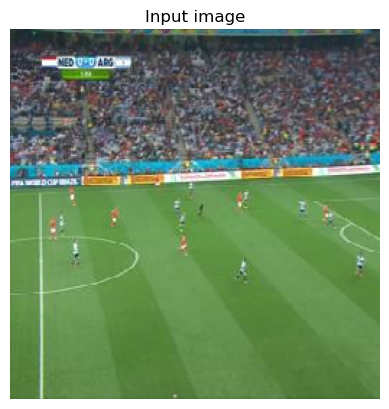

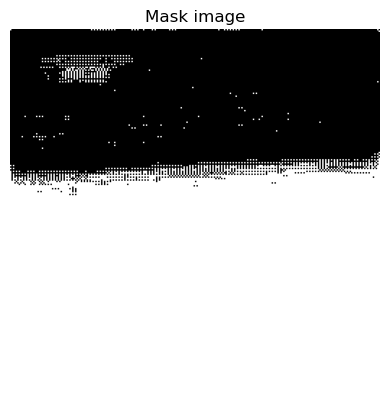

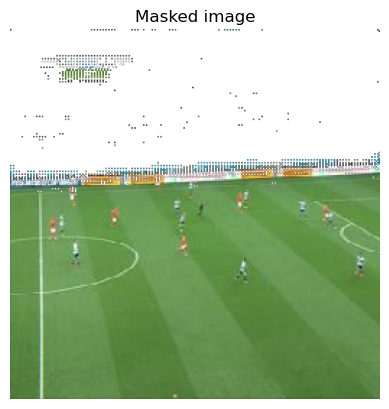

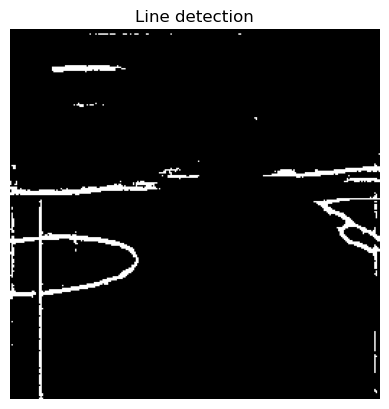

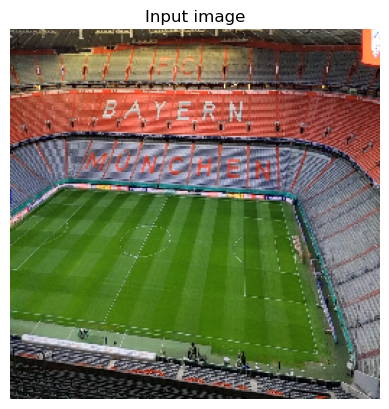

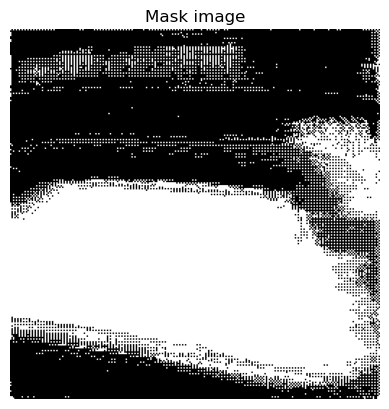

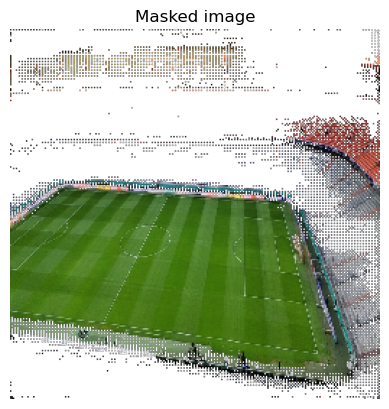

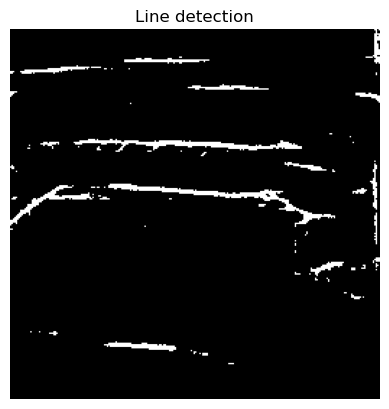

In [136]:
model = doublePix2Pix(are_trained=True)
model.fit()
input_im = tf.io.read_file('soccer_seg_detection/train_phase_1/001_AB.jpg')
# input_im = tf.io.read_file('Data_Subset/1580917244346.jpg')
input_im = tf.io.decode_jpeg(input_im)
# input_im = tf.io.decode_png(input_im)
input_im = input_im[:, :256]
res = model.predict(input_im)

input_im = tf.io.read_file('Data_Subset/1580917244346.jpg')
input_im = tf.io.decode_png(input_im)
res = model.predict(input_im)


As expected, the result is not very convincing. Our model requiring longer training in the case of TV images (as well as a network architecture more suited to our problem) and generalizing rather poorly in the case of a photo taken from the stands.

However, we still see a detection and we think we have gone in the right direction.

The next step will be to link each edge map generated to another edge map from our synthetic database and to retrieve camera parameters (and therefore the position of the photographer).


### Step 3 and 4 : Implement a Siamese network to make the link between generated edge map and synthetic edge map

In these parts, we wanted to implement a Siamese network similar to the research paper cited above and manage the case of "symmetry" between parts 1 and 3 then 2 and 4 in the stadium.

Implementing this network correctly would be more time-consuming and will therefore not be discussed here. Moreover, we do not have a large enough synthetic database and the results would not be satisfactory.


Regarding the fourth step, we will need to define a discriminating element to distinguish between zones 1 and 3 then 2 and 4 of the pitch. As part of this exercise, an obvious solution would be to detect the letters of "BAYERN" present in the stands, but this would not be of great interest since it cannot be generalized to other stages.

We then thought of getting down to effectively detecting the technical areas of the coaches in order to know which side of the field we were on.


Finally, we are satisfied to have been able to establish a beginning of concrete track to answer the problem. However, more work is needed to achieve this. This project represents, in my opinion, an interesting and motivating subject of research.


## Time spent coding: 6.5 hours

## Calculation time: > 11 hours

